# <div style="border: 3px solid #FFFFF; padding: 10px; border-radius: 5px; background-color: #4484c2; text-align: center;">Preprocessing</div>

**Dataset description:**

 To tackle fake news, in this paper, we present a dataset of social media posts and articles on COVID-19 with real and fake labels. The targeted media platforms for the data collection are designated to be the ones that are actively used for social networking for peer communication and relaying information, which could be in the form
 of news, events, social phenomenon, etc. We collect both real news and fake claims that surfaced on social media on COVID-19 topic. Fake claims are collected from various fact-checking websites like Politifact, NewsChecker, Boomlive, etc., and from tools like Google fact-check-explorer and IFCN chatbot. Real news is collected from
 Twitter using verified twitter handles. We also perform exploratory data analysis and implement four machine learning baselines.

Information source per label:
* Real - Tweets from verified sources.
* Fake - Tweets, posts, articles.


Source: [Fighting an Infodemic: COVID-19 Fake News Dataset](https://arxiv.org/pdf/2011.03327)

## <div style="border: 3px solid #FFFFF; padding: 10px; border-radius: 5px; background-color: #4484c2;">Load data</div>

In [38]:
# import libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import html
from parallel_pandas import ParallelPandas

ParallelPandas.initialize(n_cpu=10, split_factor=2) # Improve performance

In [39]:
import nltk
nltk.download('stopwords', quiet=True)
nltk.download('words', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('averaged_perceptron_tagger_eng', quiet=True)
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.util import ngrams, bigrams, trigrams

In [40]:
# load datasets
DATA = 'data/'
test = pd.read_csv(DATA + 'Constraint_English_Test.csv', delimiter=';', encoding='utf-8')
train = pd.read_csv(DATA + 'Constraint_English_Train.csv', delimiter=';', encoding='utf-8')
val = pd.read_csv(DATA + 'Constraint_English_Val.csv', delimiter=';', encoding='utf-8')

In [41]:
# concat datasets and clean possible html codes
tweets = pd.concat([train, val, test], ignore_index=True)
tweets.drop(columns=['id'], inplace=True)
tweets['tweet'] = tweets['tweet'].apply(html.unescape)

The dataset is extract directly from internet, so it is necessary to transform html references to unicode characters. For example,  previously there were some html symbols like `&amp`, that were not transformed into the correct character and could affect the text analysis.

In [42]:
# show the structure of the dataset
# there's one column with the tweet and another with the label
tweets.head()

,tweet,label
0,The CDC currently reports 99031 deaths. In gen...,real
1,States reported 1121 deaths a small rise from ...,real
2,Politically Correct Woman (Almost) Uses Pandem...,fake
3,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,Populous states can generate large case counts...,real


## <div style="border: 3px solid #FFFFF; padding: 10px; border-radius: 5px; background-color: #4484c2;">Exploratory Data Analysis (EDA)</div>

After loading the data, the next step is Exploratory Data Analysis (EDA). This step is important to understand the data before applying any modifications or transformations. We'll start by checking the number of tweets per label.

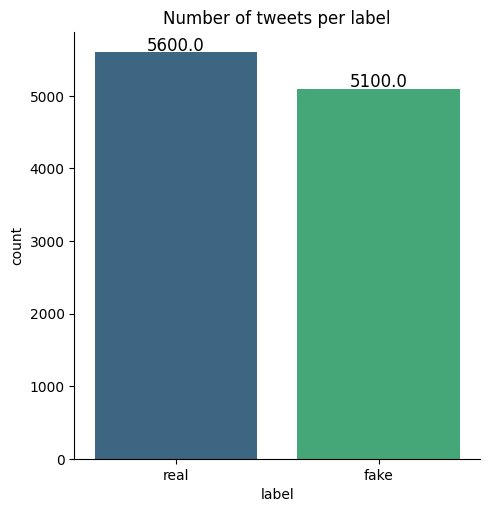

In [43]:
# PLOT - Number of tweets per label

p = sns.catplot(x='label', hue='label', kind='count', data=tweets, palette='viridis')
p.set(title='Number of tweets per label')

# Add the number of tweets
for ax in p.axes.flat:
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), 
                    textcoords='offset points')

We can see that there's a similar distribution of tweets per label. This is good because it means that the dataset is balanced and the conclusions we draw from it will be more reliable.

In [44]:
# transform dtypes
tweets = tweets.astype({"tweet": "string", "label":"category"})

In [45]:
tweets.describe()

,tweet,label
count,10700,10700
unique,10699,2
top,Our combined total of confirmed and probable c...,real
freq,2,5600


In [46]:
# Search for duplicate reviews
tweets[tweets['tweet'].isin(tweets['tweet'][tweets['tweet'].duplicated()])]

,tweet,label
5458,Our combined total of confirmed and probable c...,real
7329,Our combined total of confirmed and probable c...,real


There's a duplicate tweet in the dataset. We'll remove it in following steps.

### <div style="border: 3px solid #FFFFF; padding: 10px; border-radius: 5px; background-color: #4a44c2;">Message length</div>

As part of EDA, we'll analyze the length of the messages.


A simple analysis of the length of the messages can be useful to understand if there's any difference in the writing style of each category. We'll make a copy of the dataset so the original one is not modified, in case we need to use it later.

The message will be analyzed by the number of characters and words to check if there is any difference between the real and fake tweets.

In [47]:
tweets_analisis = tweets.copy()
tweets_analisis['length'] = tweets_analisis['tweet'].str.len()

In [48]:
# define functions to analyze the text
def word_count(tweet):
    "Split text in words and count them"
    tweet_list = tweet.split()
    return len(tweet_list)

def mean_word_length(tweet):
    "Split text in words and calculate the mean length"
    return np.mean([len(word) for word in tweet.split()])

def count_words_in_set(tweet, word_set):
    "Count the number of words in a set"
    return len([word for word in tweet.split() if word in word_set])


In [49]:
# count words
tweets_analisis['word_count'] = tweets_analisis['tweet'].apply(word_count)

In [50]:
# mean word length
tweets_analisis['mean_word_length'] = tweets_analisis['tweet'].apply(mean_word_length)

In [51]:
# peek at the data
tweets_analisis.head()

,tweet,label,length,word_count,mean_word_length
0,The CDC currently reports 99031 deaths. In gen...,real,190,29,5.586207
1,States reported 1121 deaths a small rise from ...,real,129,18,6.222222
2,Politically Correct Woman (Almost) Uses Pandem...,fake,131,16,7.250000
3,#IndiaFightsCorona: We have 1524 #COVID testin...,real,204,27,6.592593
4,Populous states can generate large case counts...,real,231,42,4.523810


After these operations, we have three new columns in the dataset:
* `lenght` - Number of characters in the tweet.
* `word_count` - Number of words.
* `mean_word_length` - Average word length.

Let's visualize the results.

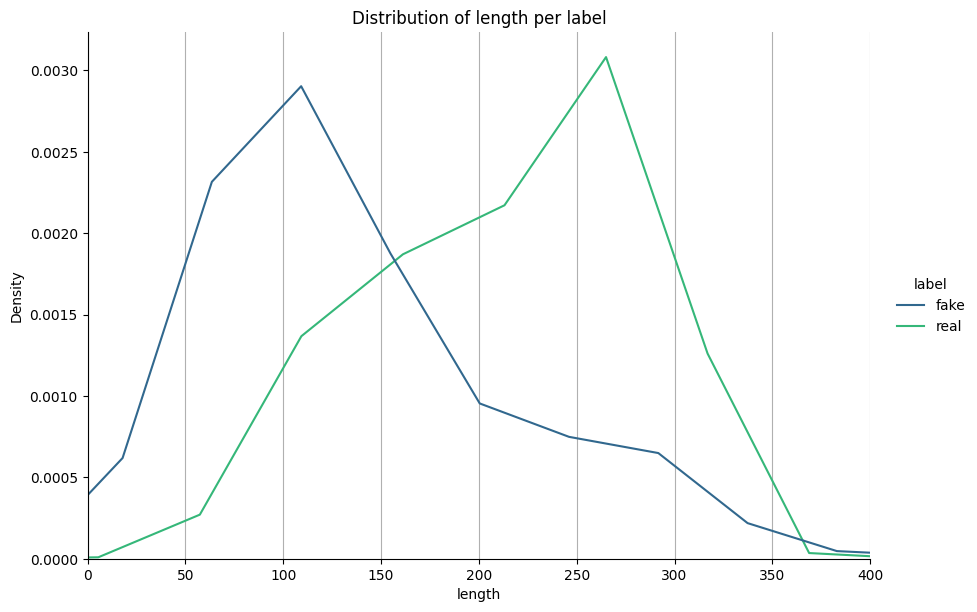

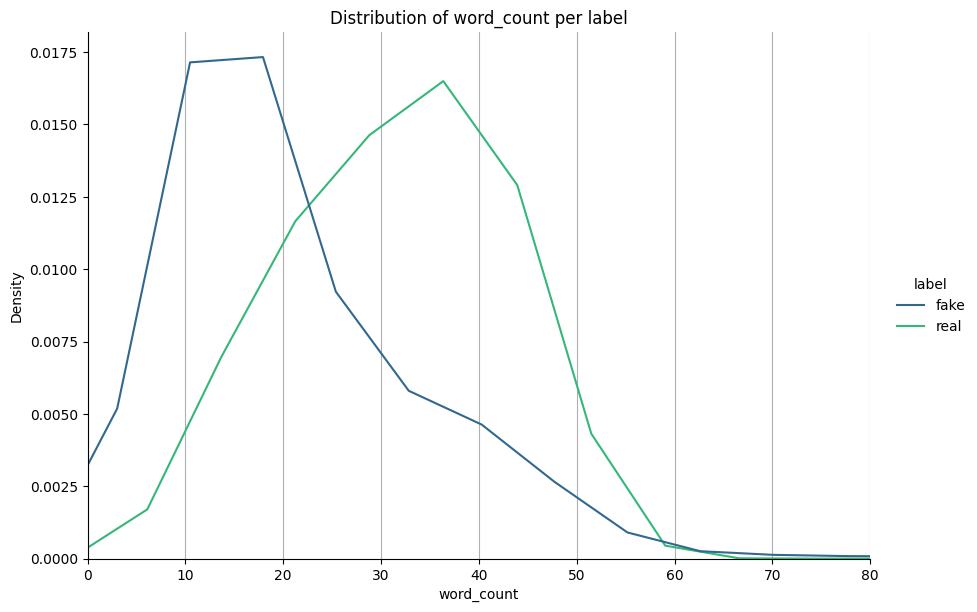

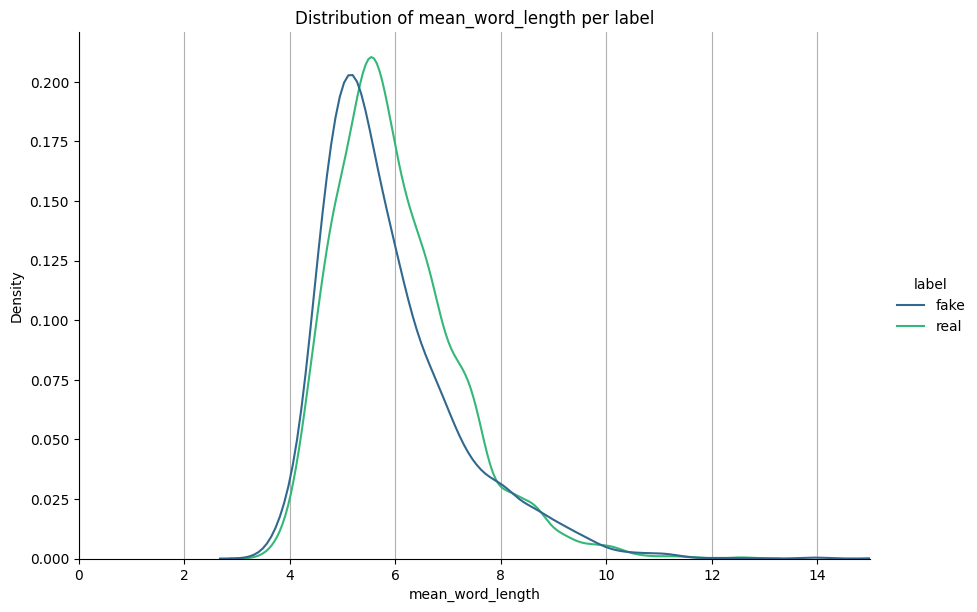

In [52]:
show_limited = True # whether to cut the x-axis or not, true for clearer visualization
features = tweets_analisis.columns.tolist()[2:]
features_limits = [(features[0], 400), (features[1], 80), (features[2], 15)]

for feature, x_limit in features_limits:
    p = sns.displot(tweets_analisis, x=feature, hue='label', palette='viridis', height=6, aspect=1.5, kind='kde')
    p.ax.grid(axis='x')
    if show_limited:
        p.set(title=f'Distribution of {feature} per label', xlim=(0, x_limit))
    else:
        p.set(title=f'Distribution of {feature} per label')

Taking a look at the plots above, we can extract some insights:
* Regarding the **number of characters**, fake messages tent to have less than 200 while real messages have its peak around 300 characters.
* The **number of words** is also higher in real messages with around 30 to 40 words, while most of fake messages have between 10 to 20 words.
* The **mean length of a word** is similar but slightly higher in real messages.

These results suggest that real messages are usually longer and more detailed than fake messages. Therefore, we can extract that real messages contain more information than fake messages with a better structred text or include more links and hashtags. We have to take into account that the tweets haven't been preprocessed yet, so it includes all the characters and links.

### <div style="border: 3px solid #FFFFF; padding: 10px; border-radius: 5px; background-color: #4a44c2;">Word Cloud</div>

Word cloud is a great way to have a quick look at the most common words in the dataset. We'll create a word cloud for both real and fake messages. In this case, we will remove stopwords, for example "the", "is", "and" and other words that don't provide much information, as links.

In [53]:
# import package
from wordcloud import WordCloud

In [54]:
# group messages by label
real_messages = (" ").join(tweets["tweet"][tweets['label'] == 'real'])
fake_messages = (" ").join(tweets["tweet"][tweets['label'] == 'fake'])

In [55]:
# deal with stopwords and other useless words
stopwords_wordcloud = set(stopwords.words('english'))
stopwords_wordcloud.update(['https', 'co', 't'])

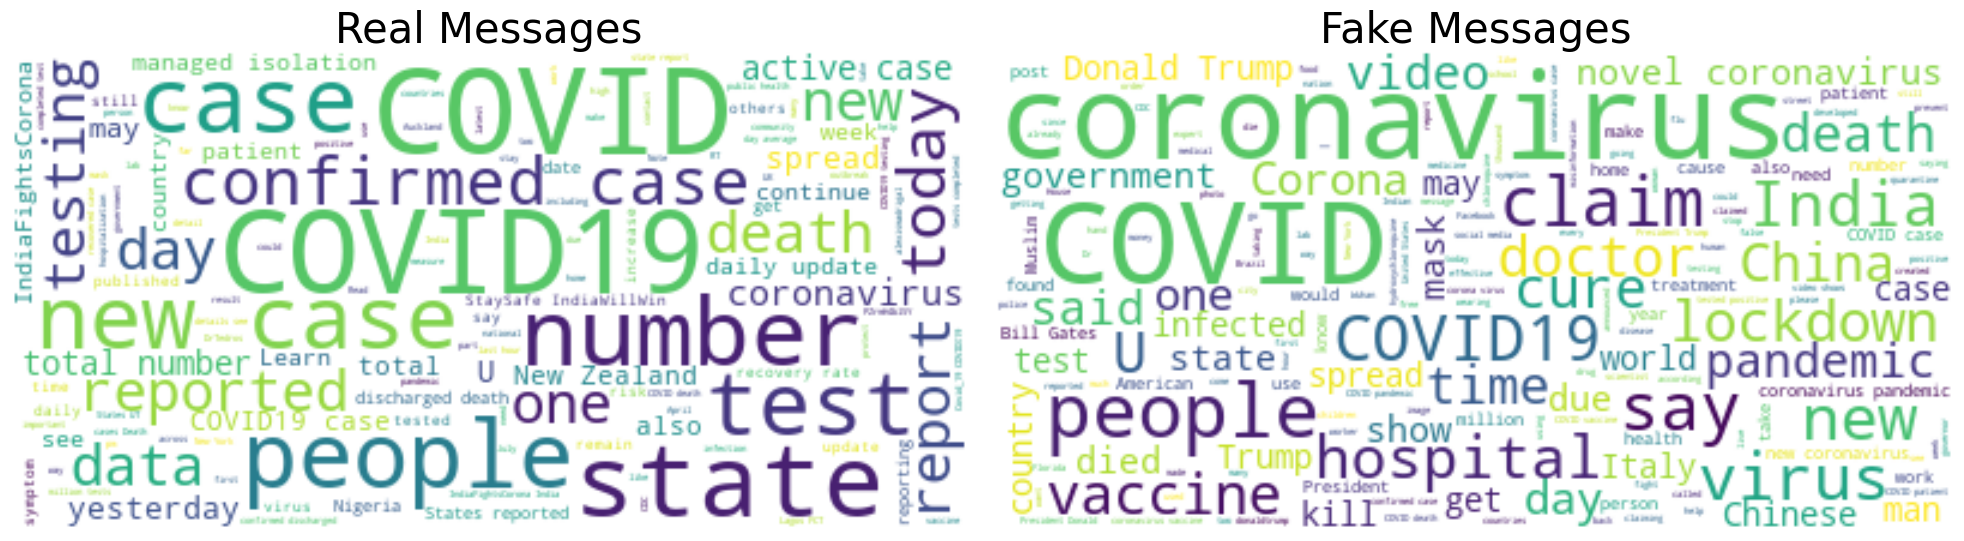

In [56]:
plt.figure(figsize=(20, 10)) 
messages = [real_messages, fake_messages]
titles = ["Real Messages", "Fake Messages"]

for idx, text in enumerate(messages):
    plt.subplot(1, 2, idx + 1)
    # set max_font_size to get more words
    wordcloud = WordCloud(background_color='white', max_font_size=50, random_state=42, 
                          stopwords=stopwords_wordcloud).generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(titles[idx], fontsize=30)  

plt.subplots_adjust(wspace=0.3) 
plt.tight_layout(pad=2.0)      
plt.show()

We can see the most important words in the dataset:

- Real messages: "case", "confirmed", "data", "report", "testing", "people", "daily update", "total".

- Fake messages: "claim", "virus", "time", "say", "die", "pandemic", "lockdown", "Donald Trump", "government", "video", "kill", "China".

No relevant information can be extracted from the wordclouds, however, we can see that real messages contain words with informational intent, while fake messages contain more variety of words. It's specially interesting to see that "Donald Trump" is a word that appears in fake messages, which could mean that fake messages are more likely to be related or influenced by political issues.

-------------

In theory, real messages are more structured, longer and contain more information, so they will have a higher number of stopwords. Let's check if this assumption is true.

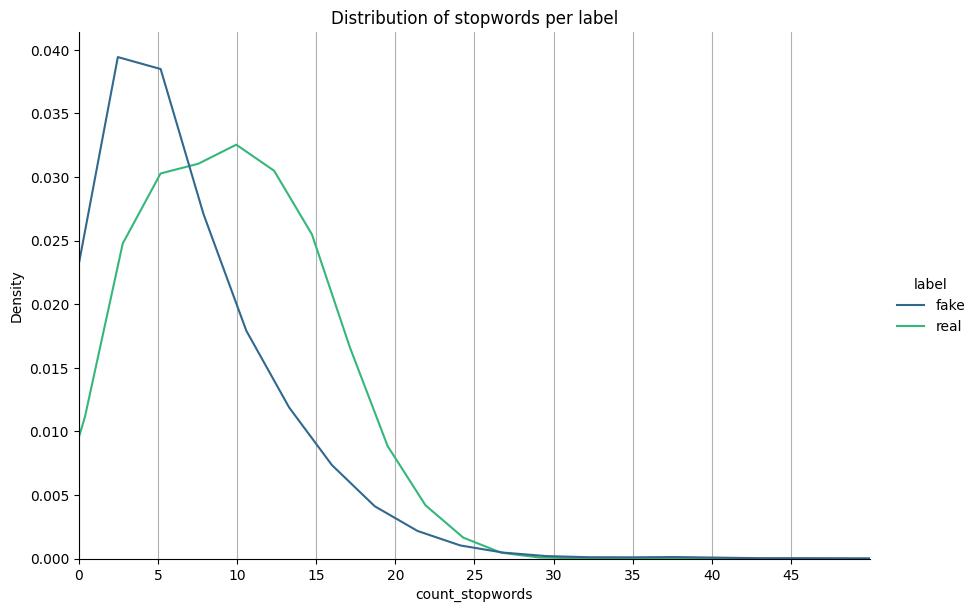

In [59]:
# PLOT - count stopwords per label
tweets_analisis['count_stopwords'] = tweets_analisis['tweet'].apply(lambda x: count_words_in_set(x, stopwords_wordcloud))

p = sns.displot(tweets_analisis, x="count_stopwords", hue='label', palette='viridis', height=6, aspect=1.5, kind='kde')
p.ax.grid(axis='x')
p.ax.set_xticks(np.arange(0, 50, 5))
p.set(title='Distribution of stopwords per label', xlim=(0, 50))

We can see that real messages have more stopwords than fake messages. This is consistent with the previous analysis, where we saw that real messages are longer, contain more information and are more structured.

-------------

As we are working with texts from social media, it's also interesting to check the number of links and hastags attached to the messages.

In [61]:
def count_links(tweet):
    "Count the number of links in a tweet"
    return len([word for word in tweet.split() if 'http' in word])

def count_hashtags(tweet):
    "Count the number of hashtags in a tweet"
    return len([word for word in tweet.split() if '#' in word])

In [62]:
tweets_analisis['count_links'] = tweets_analisis['tweet'].apply(count_links)
tweets_analisis['count_links'].groupby(tweets_analisis['label'], observed=True).value_counts(sort=False)

label  count_links
fake   0              3455
       1              1225
       2               419
       3                 1
real   0              1709
       1              2543
       2              1329
       3                 7
       4                10
       14                1
       52                1
Name: count, dtype: int64

Instead of a plot, it's better to look at raw data. We can see that usually, fake messages don't have any link and while a higher number of real messages contain at least one link.

In [63]:
tweets_analisis[tweets_analisis['count_links']==14]['tweet'].values

<StringArray>
['I\'m so happy that we’re able to do something very concrete that will help people” says Cynthia Ogden who leads a team at the National Health and Nutrition Examination Survey. The team turned their lab vehicles into mobile #COVID19 testing sites: https://t.co/JDbd7PMZ4z. https://t.co/B1pBH5j6ul\r\nA statewide survey of Indiana residents in late April estimated that #COVID19 infections were 10 times that of reported cases which is in line with previous antibody studies. Learn more in @CDCMMWR: https://t.co/wsN4MvDIKk. https://t.co/4bcpBPulRN\r\nLate April/early May antibody tests from some Atlanta households showed most residents had not been infected with #COVID19. Black residents had higher rates of past infection highlighting the need to address racial & ethnic health inequities. Learn more: https://t.co/LXO2LpafJq. https://t.co/liNvsdrkQ8\r\nParents: Help your grad stay healthy no matter where life takes them. Whether it’s finding a doctor scheduling checkups filling

Above there's a message with 14 links that is clearly an outlier. However, it looks like an interview or a report. We'll keep it for now.

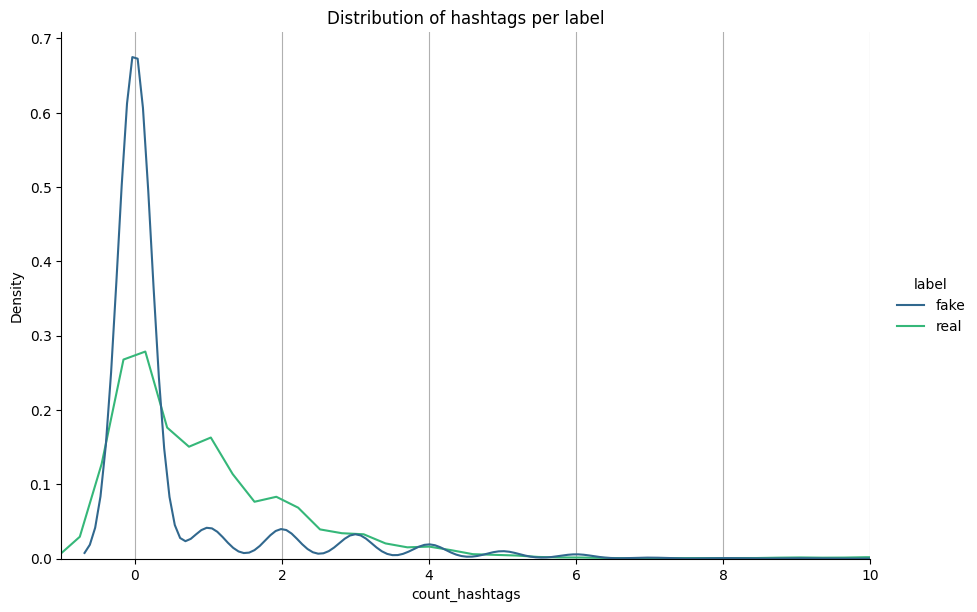

In [90]:
tweets_analisis['count_hashtags'] = tweets_analisis['tweet'].apply(count_hashtags)
p = sns.displot(tweets_analisis, x='count_hashtags', hue='label', palette='viridis', height=6, aspect=1.5, kind='kde')
p.set(title='Distribution of hashtags per label', xlim=(-1, 10))
p.ax.grid(axis='x')

The x axis of the plot has been limited to 10 hashtasgs, for a better visualization. However, there are real messages with more than 10 hashtags, while fake messages usually have less than 6 hashtags.


In general, real messages contain more links and hashtags than fake messages which implies that real tweets shows proves or references to the information provided and also are written with the intention of reaching a wider audience with a higher number of hashtags. However, this information might be affected by the data source, as real messages are only taken from Twitter, which is a platform that allows these kind of interactions while fake messages are taken from different sources.

## <div style="border: 3px solid #FFFFF; padding: 10px; border-radius: 5px; background-color: #4484c2;">Preprocessing</div>

After the EDA, we'll start the preprocessing the dataset. In this phase, we will manipulate the tweets to remove the links, mentions and hashtags and perform other operations to clean the text and continue with a more complex analysis of the content and writing style.

In [88]:
# make a copy of the dataset to prevent unwanted changes
processed_tweets = tweets.copy()

In [89]:
# as we saw before, there are some tweets that are duplicated
processed_tweets = processed_tweets.drop_duplicates(subset='tweet', keep='first')

### <div style="border: 3px solid #FFFFF; padding: 10px; border-radius: 5px; background-color: #4a44c2;">Tokenization</div>

Tokenization consists of splitting the text into words or sentences. In this case, we'll split the text into words as we are not working with a complex and elaborated text that can be split into sentences, instead, we are working with tweets that are usually short and concise.

In [93]:
# remove links that start with 'http' --> https://t.co/... or http://www...
import re

def filter(tweet:str):
    # https://stackoverflow.com/questions/3809401/what-is-a-good-regular-expression-to-match-a-url#3809435
    return re.sub(r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)','',tweet)


processed_tweets['tweet_nolinks'] = processed_tweets['tweet'].apply(filter)

In [94]:
# tokenize the tweets
processed_tweets['tokens'] = processed_tweets['tweet_nolinks'].apply(word_tokenize)

In [95]:
# remove punctuation symbols, also # and @ tokens
# Remove tokens if they are made up entirely of non-alphanumeric symbols:\n",
# @ # `` '' are removed\n",
# non-zero, 's, are not removed\n",
def word_check(w:str)->bool:
    s = True
    for c in w:
        s = s and not c.isalnum()
    return not s
processed_tweets['tokens'] = processed_tweets['tokens'].apply(lambda x: [word for word in x if word_check(word)])

In [96]:
# Remove stopwords (case insensitive)
# we don't want to transform the tweets
stop_words = set(stopwords.words('english'))
processed_tweets['tokens'] = processed_tweets['tokens'].apply(lambda tokens: [word for word in tokens if word.lower() not in stop_words])

In [97]:
def plot_feature(feature:str, limit:int = 20) -> None:
    """Function to plot the first 'limit' most common words in the feature column"""
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))

    type = ['real', 'fake']
    for i, t in enumerate(type):
        words = processed_tweets[feature][processed_tweets['label'] == t].sum()
        words = pd.Series(words).value_counts().sort_values(ascending=False).head(limit)
        b = sns.barplot(x=words.values, y=[str(index) for index in words.index], hue=[str(index) for index in words.index], palette='viridis', ax=ax[i], dodge=False, legend=False)
        b.set_title(f'Top {limit} {feature} in {t} tweets')

    plt.tight_layout()
    plt.show()

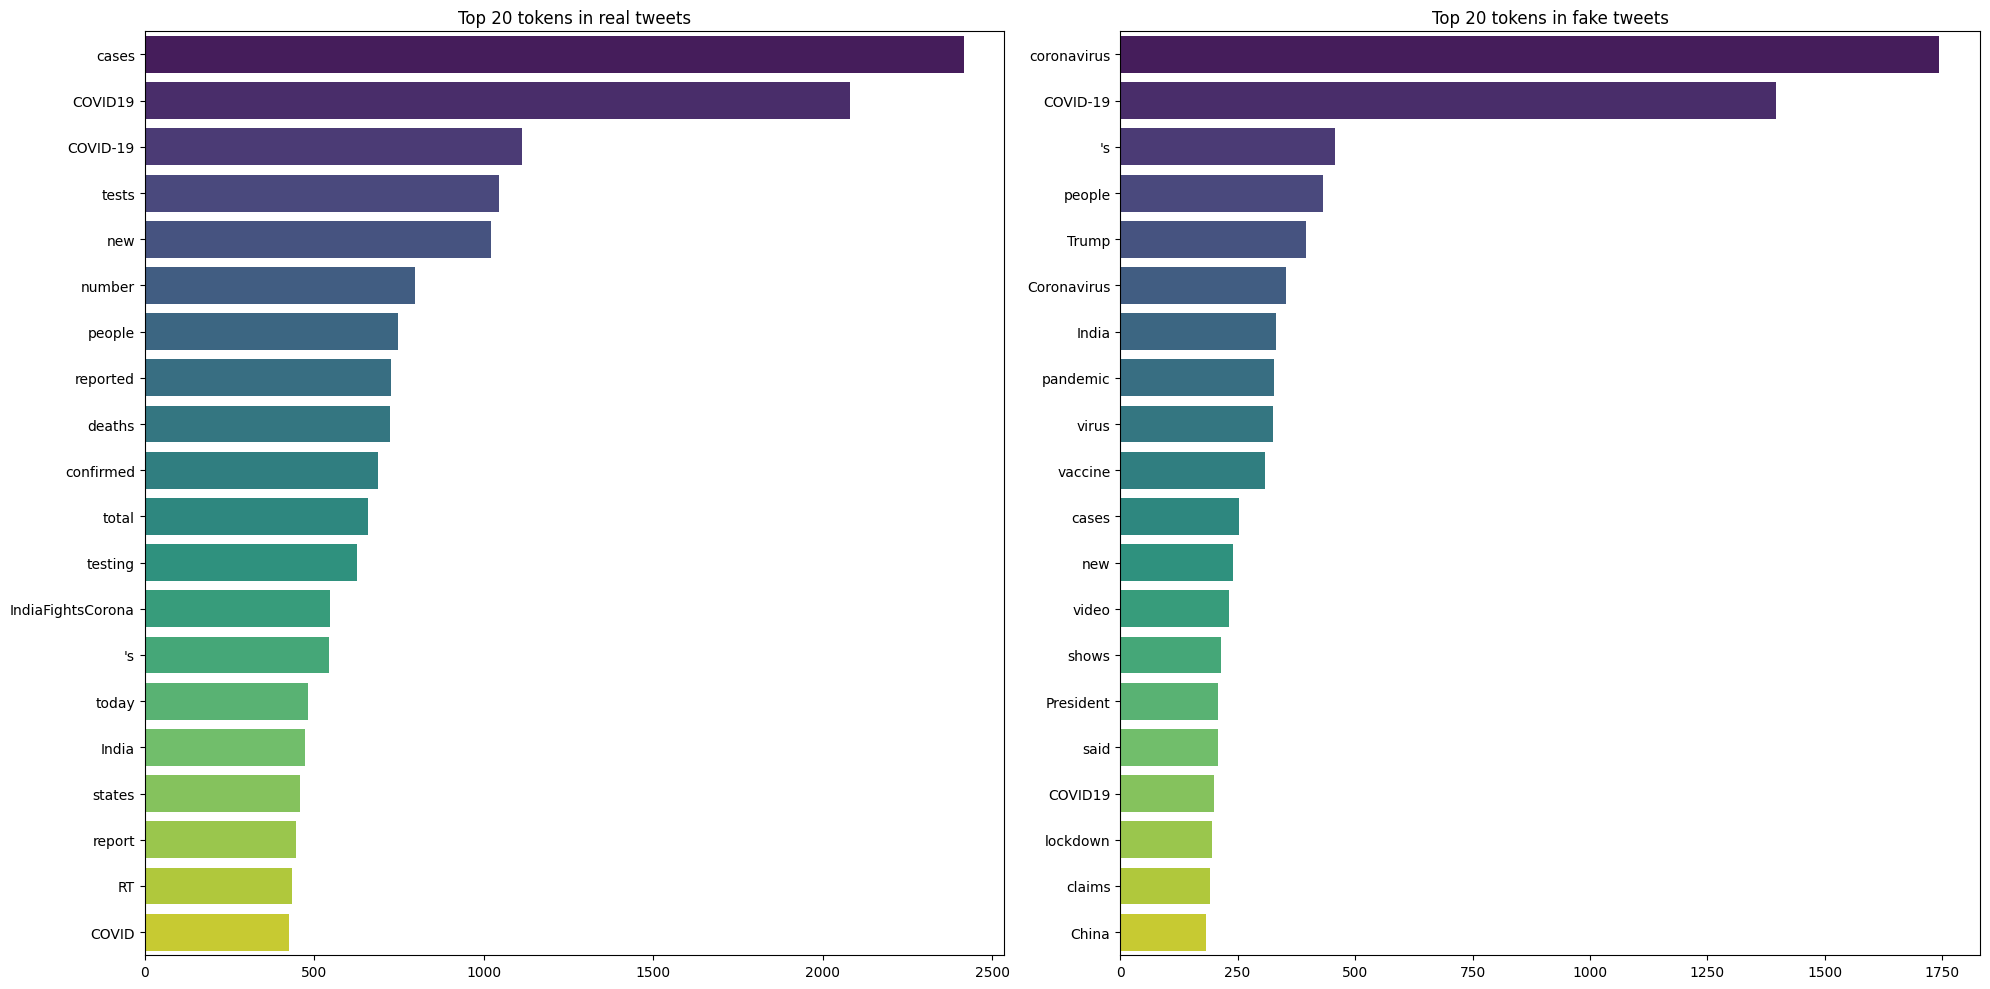

In [98]:
# PLOT MOST COMMON WORDS BY LABEL
plot_feature('tokens')

From the word cloud we could easily identify the most common words, but we weren't able to see a ranking of them. The graph above shows it.

We have found something really interesting:

- Real messages: top word for naming the virus is "covid-19".
- Fake messages: top word for naming the virus is "coronavirus".

This difference means that while real messages are more formal and use the official name of the virus, fake messages use the most popular name and even others like "Corona" or "COVID". It might be interesting to check if names like "china virus" or "chinese virus" appear together, to do this will have to group the words into N-grams.

### <div style="border: 3px solid #FFFFF; padding: 10px; border-radius: 5px; background-color: #4a44c2;">N-grams</div>

N-grams are contiguous sequences of 'n' items, that can be characters, words, or even syllables. They play an important role in capturing patterns and relationships within a sequence of words. We'll only work with bigrams and trigrams, as they are the most common n-grams used in text analysis.

In [99]:
# create bigrams and trigrams
processed_tweets['bigrams'] = processed_tweets['tokens'].apply(lambda tokens: list(bigrams(tokens)))
processed_tweets['trigrams'] = processed_tweets['tokens'].apply(lambda tokens: list(trigrams(tokens)))

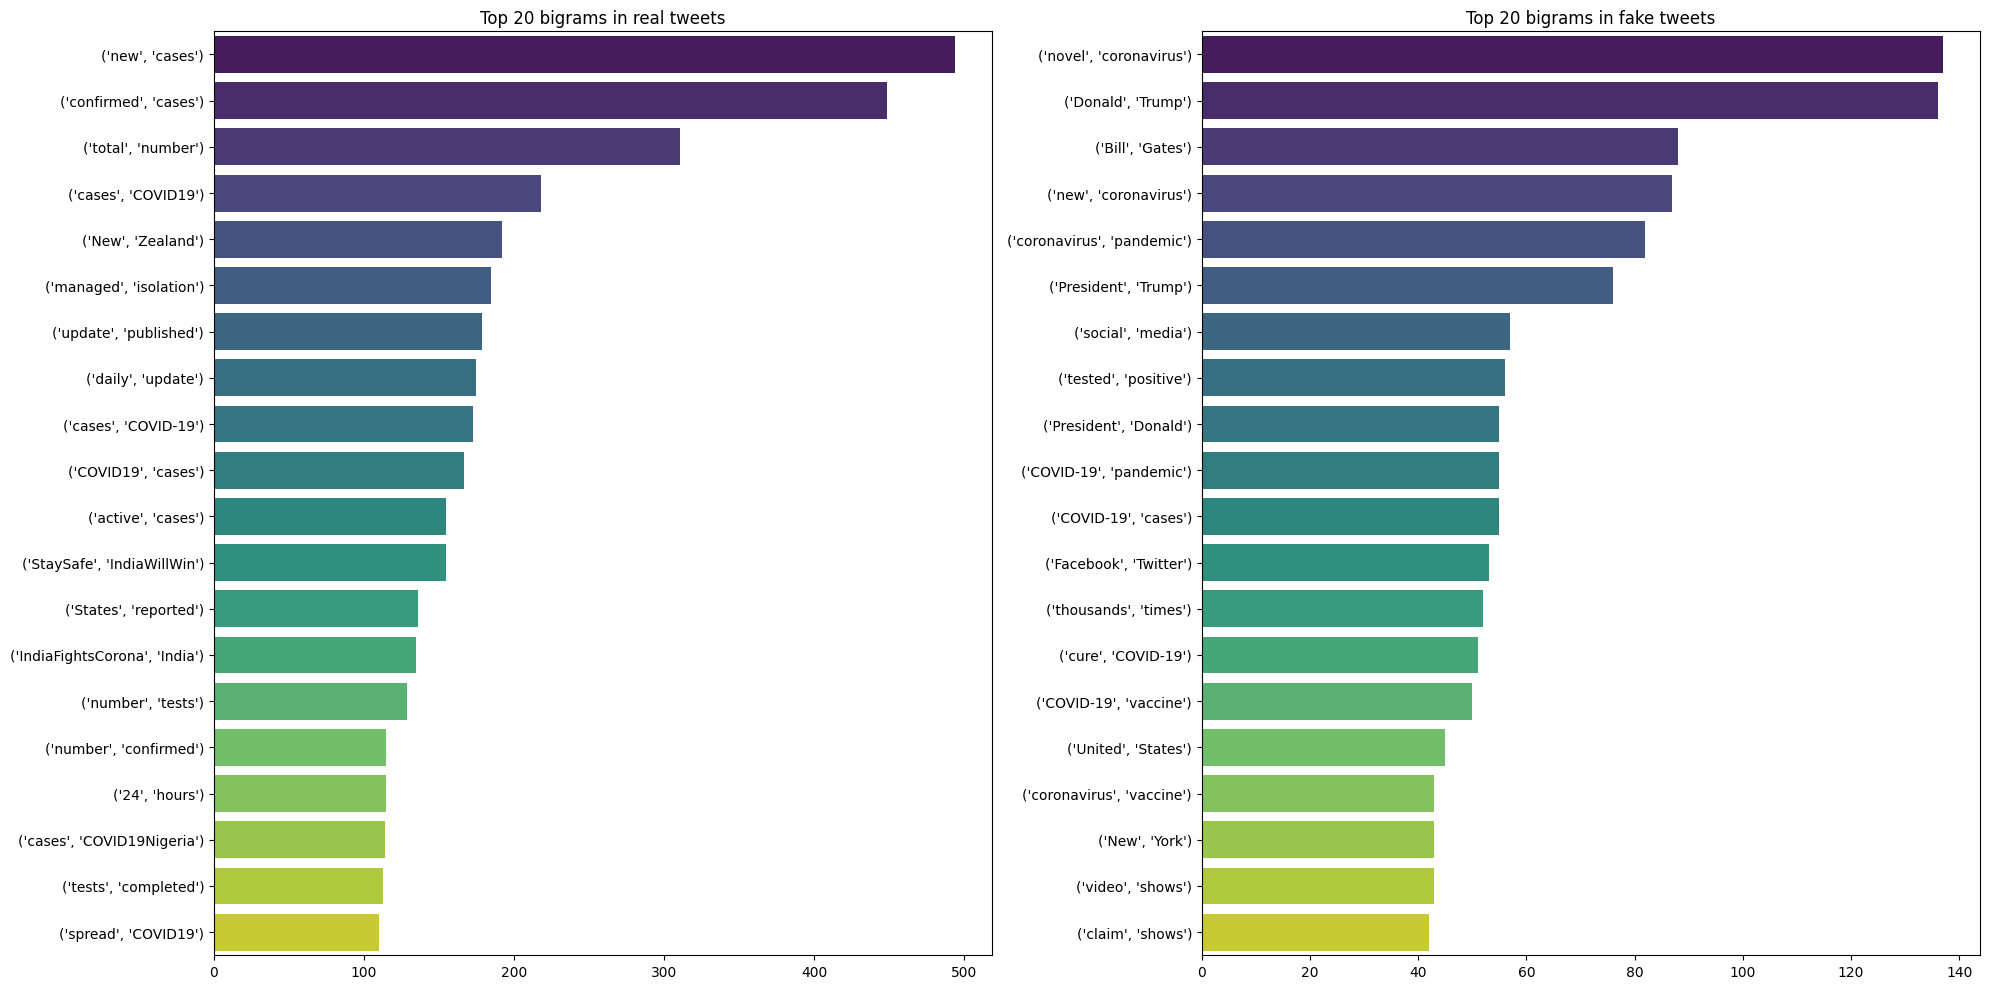

In [34]:
plot_feature('bigrams')

The top 3 most frequent bigram for real messages are "new cases", "confirmed cases" and "total number". These bigrams express the idea of a report or a daily update to show the current situation of the pandemic.

On the other hand, the top 3 most frequent bigram for fake messages are "novel coronavirus", "Donald Trump" and "Bill Gates".

<details>
<summary>Click here to read more about Donald Trump and Bill Gates</summary>

1. Donald Trump

He was the president of the United States during the pandemic and made several controversial statements about the virus. Since the beginning, he questioned the severity and scope of the pandemic comparing it to a simple flu. He also said some preventive measures, such as the use of masks, were unuseful. And he shoked the scientific community with his assessments about possible treatments with disinfectants or with the announcement that he himself was taking preventive medication with hydroxychloroquine.  
This short text is extracted from the description of this video: [Las frases de TRUMP sobre el CORONAVIRUS: de minimizarlo a dar positivo - RTVE](https://www.youtube.com/watch?v=awsCf2gMaFk), which helped us to understand the context of people who spread fake news. Some of them copy Trump's statements or cite him as a source of information.

2. Bill Gates

He is the co-founder of Microsoft and has invested billions in global health care. In 2015 at a TED talk, he warned about the possibility of a global pandemic and the need to be prepared for it. This talk has been used by conspiracy theorists to say that rich people like Gates knew about the pandemic and even created it. For more information, you can check this article: [Cómo Bill Gates se convirtió en el centro de tantas teorías de la conspiración en medio de la pandemia](https://www.bbc.com/mundo/noticias-52952518)
</details>

Now, let's analyze the trigrams.

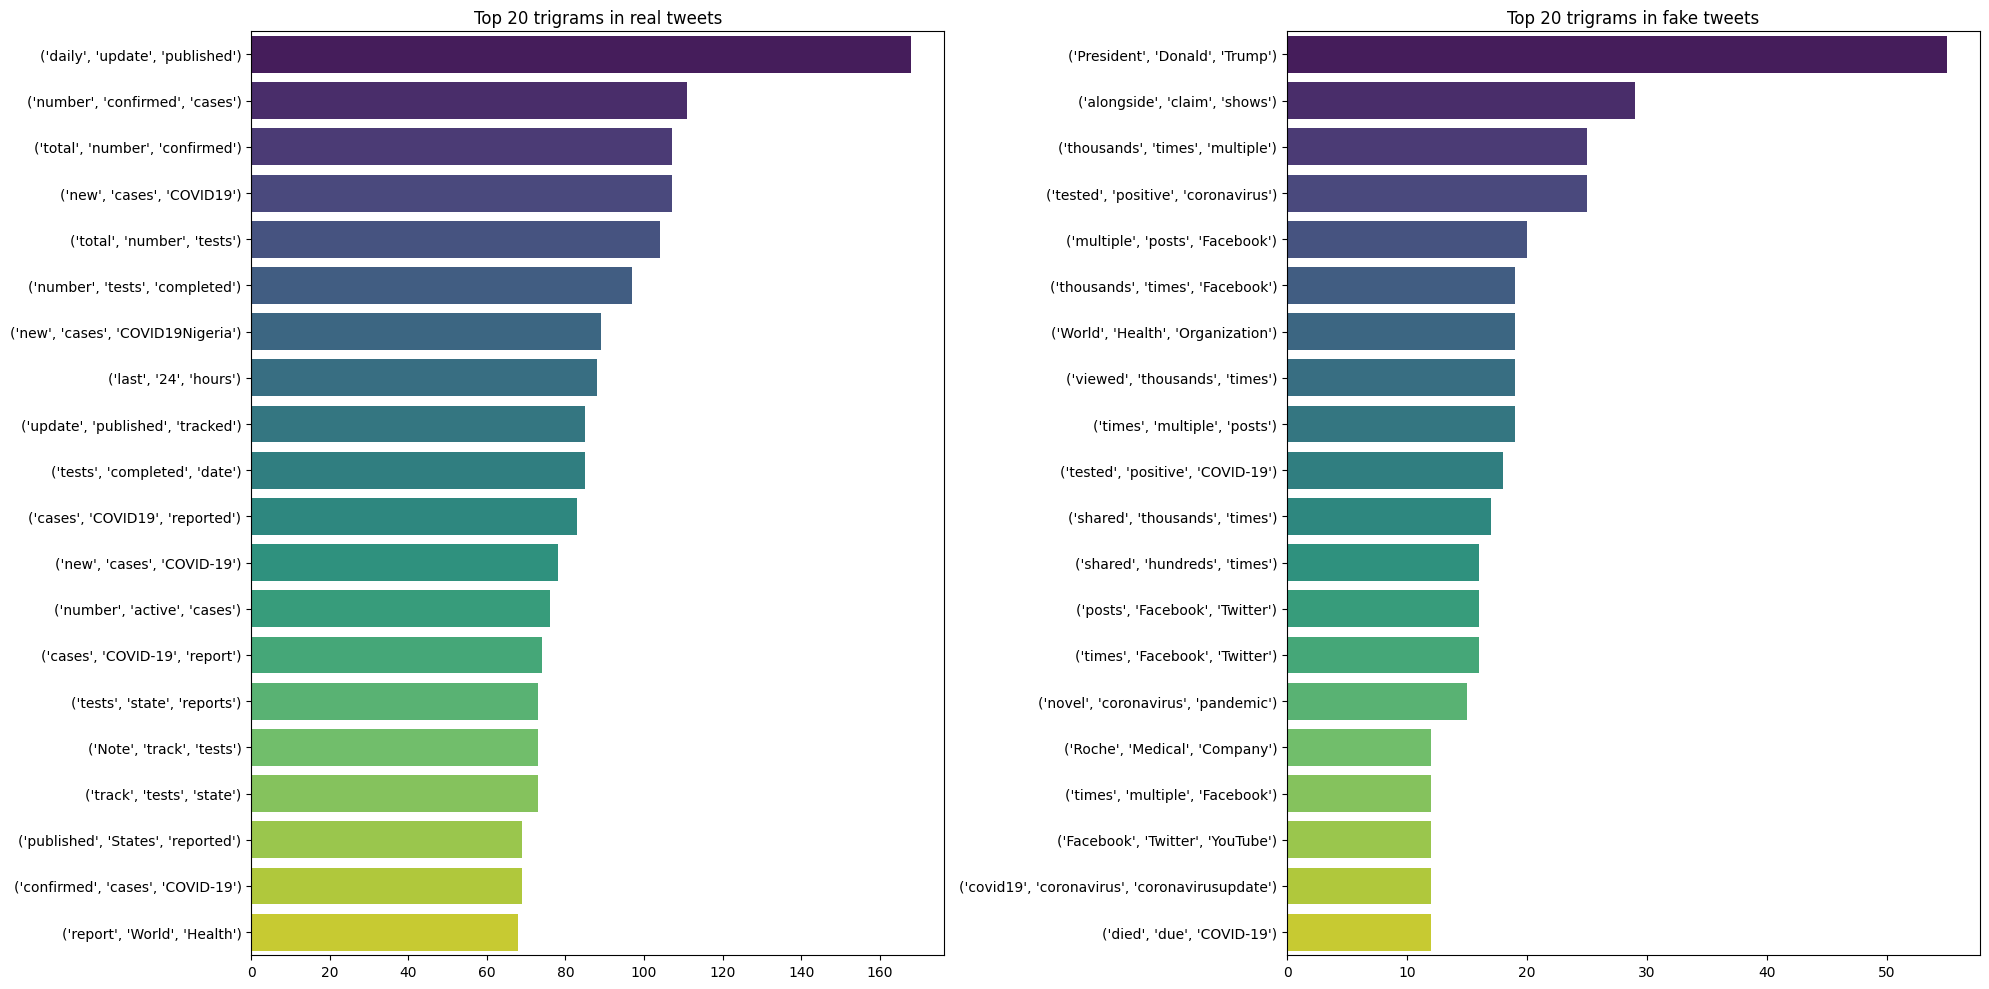

In [100]:
plot_feature('trigrams')

Trigrams confirm some of the previous insights:

- Real messages: talk about "daily update published" and "number confirmed cases". Again, these are related with a report and with an informative intent.
- Fake messages: the most frequent trigram is "President Donald Trump". 

### <div style="border: 3px solid #FFFFF; padding: 10px; border-radius: 5px; background-color: #4a44c2;">Part Of Speech tagging (POS)</div>

In [36]:
processed_tweets['pos_tags'] = processed_tweets['tokens'].apply(nltk.pos_tag)

In [37]:
processed_tweets['pos_tags'].head()

0    [(CDC, NNP), (currently, RB), (reports, VBZ), ...
1    [(States, NNS), (reported, VBD), (1121, CD), (...
2    [(Politically, RB), (Correct, NNP), (Woman, NN...
3    [(IndiaFightsCorona, NNP), (1524, CD), (COVID,...
4    [(Populous, JJ), (states, NNS), (generate, VBP...
Name: pos_tags, dtype: object

In [38]:
words = processed_tweets['pos_tags'][processed_tweets['label'] == 'real'].sum()

In [39]:
processed_tweets['pos_tags'][processed_tweets['label'] == 'real']

0        [(CDC, NNP), (currently, RB), (reports, VBZ), ...
1        [(States, NNS), (reported, VBD), (1121, CD), (...
3        [(IndiaFightsCorona, NNP), (1524, CD), (COVID,...
4        [(Populous, JJ), (states, NNS), (generate, VBP...
5        [(Covid, NNP), (Act, NNP), (found, VBD), (aver...
                               ...                        
10693    [(RT, NNP), (WHOAFRO, NNP), (COVID19, NNP), (v...
10695    [(CoronaVirusUpdates, NNS), (State-wise, NNP),...
10697    [(296, CD), (new, JJ), (cases, NNS), (COVID19N...
10698    [(RT, NNP), (CDCemergency, NNP), (DYK, NNP), (...
10699    [(half, NN), (pregnant, JJ), (women, NNS), (re...
Name: pos_tags, Length: 5599, dtype: object

In [40]:
words

[('CDC', 'NNP'),
 ('currently', 'RB'),
 ('reports', 'VBZ'),
 ('99031', 'CD'),
 ('deaths', 'NNS'),
 ('general', 'JJ'),
 ('discrepancies', 'NNS'),
 ('death', 'NN'),
 ('counts', 'NNS'),
 ('different', 'JJ'),
 ('sources', 'NNS'),
 ('small', 'JJ'),
 ('explicable', 'JJ'),
 ('death', 'NN'),
 ('toll', 'NN'),
 ('stands', 'VBZ'),
 ('roughly', 'RB'),
 ('100000', 'CD'),
 ('people', 'NNS'),
 ('today', 'NN'),
 ('States', 'NNS'),
 ('reported', 'VBD'),
 ('1121', 'CD'),
 ('deaths', 'NNS'),
 ('small', 'JJ'),
 ('rise', 'NN'),
 ('last', 'JJ'),
 ('Tuesday', 'NNP'),
 ('Southern', 'NNP'),
 ('states', 'NNS'),
 ('reported', 'VBD'),
 ('640', 'CD'),
 ('deaths', 'NNS'),
 ('IndiaFightsCorona', 'NNP'),
 ('1524', 'CD'),
 ('COVID', 'NNP'),
 ('testing', 'VBG'),
 ('laboratories', 'NNS'),
 ('India', 'NNP'),
 ('25th', 'CD'),
 ('August', 'NNP'),
 ('2020', 'CD'),
 ('36827520', 'CD'),
 ('tests', 'NNS'),
 ('done', 'VBN'),
 ('ProfBhargava', 'NNP'),
 ('DG', 'NNP'),
 ('ICMRDELHI', 'NNP'),
 ('StaySafe', 'NNP'),
 ('IndiaWillWin',

In [41]:
from collections import Counter

def plot_tags(limit:int = 20):
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))

    type = ['real', 'fake']
    for i, t in enumerate(type):
        pos_by_label = processed_tweets['pos_tags'][processed_tweets['label'] == t]
        tags = pos_by_label.apply(lambda x: [tag for _, tag in x]).sum()
        tags = pd.Series(tags).value_counts().sort_values(ascending=False).head(limit)
        b = sns.barplot(x=tags.values, y=[str(index) for index in tags.index], hue=[str(index) for index in tags.index], palette='viridis', ax=ax[i], dodge=False, legend=False)
        b.set_title(f'Top {limit} {feature} in {t} tweets')

    plt.tight_layout()
    plt.show()

### <div style="border: 3px solid #FFFFF; padding: 10px; border-radius: 5px; background-color: #4a44c2;">Named Entity Recognition (NER)</div>

<div class="alert alert-block alert-info">
<b>💡NOTE:</b> The following cell will run for almost 10 minutes.
</div>

In [ ]:
# WARNING: 10 minutes

nltk.download('maxent_ne_chunker_tab', quiet=True)
processed_tweets['ne_tags'] = processed_tweets['pos_tags'].p_apply(nltk.ne_chunk)

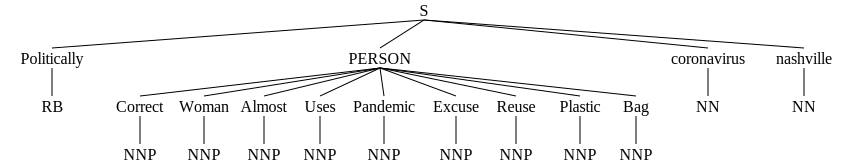

In [43]:
from collections import defaultdict

from pandas import DataFrame


d_types:set[str] = set()
for i in processed_tweets['ne_tags']:
    for j in i.subtrees(lambda x:x.label()!='S'):
        d_types.add(j.label())

d_type_entity:defaultdict[str,list[list[str]]] = defaultdict(list)

processed_tweets.reset_index(inplace=True)

for i in processed_tweets['ne_tags']:
    for j in d_types:
        d_type_entity[f"NE_{j}"].append([])
    
    for j in i.subtrees(lambda x:x.label()!='S'):
        tk, _ = zip(*j.leaves())
        entity = ' '.join(tk)
        d_type_entity[f"NE_{j.label()}"][-1].append(entity)


In [44]:
# When rerunning these cells, drop the columns generated here
# processed_tweets.drop(list(d_type_entity.keys()),axis=1,inplace=True)
processed_tweets = processed_tweets.join(pd.DataFrame(d_type_entity))

In [45]:
plot_feature('NE_PERSON')

(PERSON States/NNS)
('reported', 'VBD')
('1121', 'CD')
('deaths', 'NNS')
('a', 'DT')
('small', 'JJ')
('rise', 'NN')
('from', 'IN')
('last', 'JJ')
('Tuesday', 'NNP')
('.', '.')
(GPE Southern/JJ)
('states', 'NNS')
('reported', 'VBD')
('640', 'CD')
('of', 'IN')
('those', 'DT')
('deaths', 'NNS')


### <div style="border: 3px solid #FFFFF; padding: 10px; border-radius: 5px; background-color: #4a44c2;">Text Complexity</div>

In this section, we will explore how readable the text is and what type of audience it is intended for. Readability Index is a number that indicates how easy it is to read a text. The lower the number, the more difficult it is.

Textstat is a Python library that process a text and calculate this index. Here's a table with the corresponding values:
| Score |    Difficulty     |
|-------|-------------------|
|90-100 | Very Easy         |
| 80-89 | Easy              |
| 70-79 | Fairly Easy       |
| 60-69 | Standard          |
| 50-59 | Fairly Difficult  |
| 30-49 | Difficult         |
| 0-29  | Very Confusing    |

Source: [Github - textstat](https://github.com/textstat/textstat)

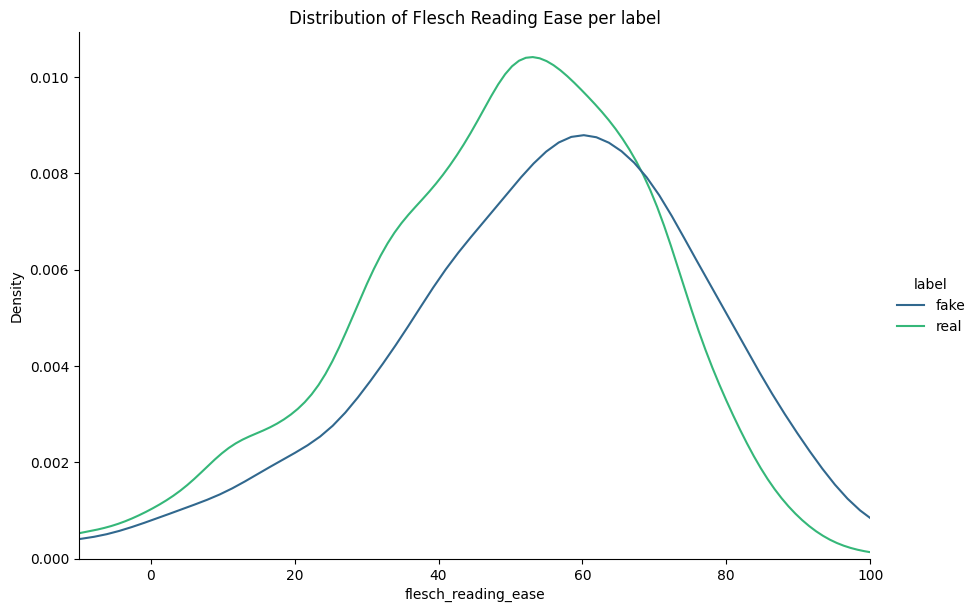

In [102]:
from textstat import flesch_reading_ease
processed_tweets['flesch_reading_ease'] = processed_tweets['tweet'].apply(flesch_reading_ease)

p = sns.displot(processed_tweets, x='flesch_reading_ease', hue='label', palette='viridis', height=6, aspect=1.5, kind='kde')
p.set(title='Distribution of Flesch Reading Ease per label', xlim=(-10, 100))

The blue line, that represents the fake messages, is tailed to the right, meaning that the text is easier to read. On the other hand, the green line, representing the real messages, is tailed to the left, meaning that the text is more difficult to read.